# Part 1: Fitting models

Math secretly has developed a lot of useful methods and ideas to work with numbers. The key is to become literate enough in both Math and Computer Science to apply it to real world data. This notebook will help you develop this literacy by learning how mathematical models can be *fitted* to data and how simple inferences can be made. We will do this with the help of unsupervised and supervised machine learning - to add a few hot keywords to get you hooked! 

## Generative models

Sometimes in the world you are presented with lots of one type of data. For instance, how many letters arrive in your email per day, how much time elapses between subsequent busses in a bus stop. According to this data you might have to make some decisions like how much time to dedicate each day to reading your inbox and how much more you need to wait in a bus stop. If you are running a bussiness, analogous decisions become more important and thus should be informed by data.
 
Lets start with a simple example. This is a data set of how many emails I got per day for 10 different days. (How many of them were important is another question...)

In [ ]:
# import useful packages 
import numpy as np
import math
import matplotlib.pyplot as plt

# initialise data set
xs = [5, 6, 10, 2, 7, 3, 1, 1, 2, 1]

This data is quite simple. It does not have any response variable - for instance how many minutes I spent looking through my emails that day. Analysis you do on this type of data is called *unupervised machine learning*. Using this data we can find patterns. In particular, with this dataset we will explore the question of how many emails I can expect to get in the future. 

A particular kind of interesting patterns data scientist often look for are clusters. Often the data you are looking at contains measurements from multiple groups mixed together. The more data there is the harder it is for human scientist to find the boundaries between groups. Generative modelling can deal with it and furthermore tell us how "confident" we should be about the generated boundaries. 



### First step

In the meantime, lets get back to the simple email example. 

We will call our random variable $X$ and it represents how many letters I got in a day.

The model we can try to fit to this data is Poisson distribution. You can read more about it [here](https://en.wikipedia.org/wiki/Poisson_distribution). The most important thing is its probability mass function which can be expressed as:

$$ Pr_X(x) = \frac{\lambda ^x e^{-\lambda}}{x!}$$

$\lambda$ is the unknow parameter that we want to estimate to know how likely are future values of $X$. If you actually opened the link, you might notice that $\lambda$ has to be greater than zero. This is an important constraint that we will return to later! 

I will write the probability mass function to make explicit the fact that $x$ depends on  $\lambda$:

$$ Pr_X(x|\lambda) = \frac{\lambda ^x e^{-\lambda}}{x!}$$

You should read that as the probability of a particular value of $x$ given $\lambda$. "|" symbol does not denote conditional probability but it is a common notation to express dependency.

We will view the entire data set `xs` as independent samples generated from this distribution.

To summarise this step, we need to pick a model (in our case, a distribution) with some tunable parameters that we will fit to the data. Also, we need to check and keep in mind the constraints.

#### Aside: Why the constaints are important?

The probability mass function expression might still have values when parameters like $\lambda$ do not obey the constraints. When it comes time to report the results of your analysis, you will have to explain why the model you choose makes sense. For instance, Poisson model has an interpretation that it closely models the number of independant events over an interval. So, we will have no problem defending this choice for emails. However, if we get a value of $\lambda$ that does not obey Poisson constraints, we cannot with clean conscience use mathematical results to support our model choice. Without the constraints, we are dealing with a totally different class of functions!


### Second step 

Now we need a function to calculare the likelihood of particular value of $\lambda$ given our data set. This is the same as plugin in $\lambda$  into our model and seeing how probable our dataset becomes.

$$lik(\lambda | x_1, ..., x_{10}) = Pr(x_1, ..., x_{10} | \lambda)$$

By the assumption that samples are independent, we can conclude:

$$Pr(x_1, ..., x_{10} | \lambda) = Pr_X(x_1 | \lambda) \times ... \times Pr_X(x_{10} | \lambda)$$

At this point your inner alarm bells should be ringing - probabilities tend to be quite small numbers and we are multiplying a bunch of them together. So to be safe, lets bring our trusted tool - the logarithm $\dagger$:

$$log(lik(\lambda | x_1, ..., x_{10})) = log(Pr_X(x_1 | \lambda) \times ... \times Pr_X(x_{10} | \lambda)) = log(Pr_X(x_1 | \lambda)) + ... + log(Pr_X(x_{10} | \lambda))$$ 

Our ultimate goal is to find the value for $\lambda$ that maximises the data sets likelihood. So using logarithm is OK as it is *monotonic* (i.e. we will still be able to distinguish higher likelihood value from the smaller one).

Using the rules of logarithm we can simplify the probability mass function $Pr_X(x|\lambda)$:

$$log(Pr_X(x|\lambda)) = log(\frac{\lambda ^x e^{-\lambda}}{x!}) = x \times log(\lambda) - \lambda - log(x!)$$

Thus, in this step we use independence assumption to find an expression for the log likelihood of our unknown parameters.

We can now write down likelihood function programatically.

In [ ]:
def fact(x):
  """
  Calculates the factorial of the given number.
  :param x: (interger greater than 0) 
  :return: (positive integer)
  """
  if x == 1:
    return x
  return x * fact(x-1)

def logPr_X(x, l): 
  """
  Calculates log probability of observing given sample under given lambda.
  :param l: (positive real) - lambda parameter
  :param x: (positive integer) - a sample form the distribution
  :return: (real)
  """
  return x * math.log(l) - l - math.log(fact(x))

def loglik(l):
  """
    Calculates log likelihood of the entire dataset under given lambda.
    :param l: (positive real) lambda parameter
    :global xs: (list of integer samples) our data set
    :return: (real)
  """
  global xs # this line is not necessary but makes it obvious that xs is 
            # defined outside the function
  prx = [logPr_X(x,l) for x in xs]
  return sum(prx) # return the sum of all log(Pr_X)'s

### Third step

We can now find the $\lambda$ that maximises the log likelihood expression. We can use calculus for that - find derivative and so on. But we can also use Computer Science. In particular we can use a function `scipy.optimize.fmin`. It takes a function with $n$ arguments and an initial guess (a list of size $n$) and returns the values for those arguments that minimise the function (also a list of size $n$). 
You might be confused - why would we want to minimise the function. Sadly, there is no `fmax` function, so we will maximise our log-likelihood function by taking its negative value. 

This is also the point where we bring our constraints associated with the model. `fmin` minimises the parameters over real numbers. But we need that $\lambda$ be in $(0; \infty)$. How good would it be to have a function that converts between real numbers and positive numbers which preserves ordering...

I am sure that at this point you are screaming at the screen '*Exponential!*'.

To use it, firstly we need to introduce temporary parameter $t$ that we will actually be using `fmin` with. Then we express $\lambda$ in terms of it:

$$\lambda = e^t$$

We will use when defining a helper function and then to recover the final result.

Word of caution: `fmin` is not a panacea, it can get stuck in local minima so give it a good initial guess if you can. 

Summary of this step: use numerical optimisation techniques to find values for parameters that maximise the likelihood. Remember to apply constraints.

In [ ]:
import scipy.optimize

def f(t):
  """
  Funtion to be optimised.
  :param t: (real) - temporary parameter
  :return: (real)
  """
  l = math.exp(t)
  return -loglik(l)

initial_guess = 2

t = scipy.optimize.fmin(f, initial_guess)

# Recover lambda
λ = math.exp(t)
print(λ)

Optimization terminated successfully.
         Current function value: 25.444330
         Iterations: 15
         Function evaluations: 30
3.7998475119767394


### Overview

You just fitted a model! Having learned the hidden parameter you can draw further inferences. The graph of the probability mass function looks pretty much right - majority of our samples is in the left side of the range where there is more probability mass.

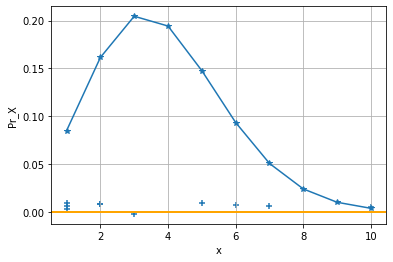

In [ ]:
step = [i + 1 for i in range(10)]
poisson = [math.exp(logPr_X(i, λ)) for i in step]

fig, ax = plt.subplots()
jitter_y = np.random.uniform(low=-0.01, high=0.01, size=len(xs))
ax.axhline(y=0, color='orange', linewidth='2')
ax.scatter(xs, jitter_y, marker='+')
ax.plot(step, poisson, marker='*')

ax.set(xlabel='x', ylabel='Pr_X')
ax.grid()


plt.show()

### More Advanced Example

That was cool, lets do it again! This time we will try to find clusters in a data using Gaussian Mixture Model.

Lets get acquainted with the data. Here are test scores of 82 students. Clusters in this dataset might indicate that there exist some teaching/learning disparities. Lets investigate it further! 

In [ ]:
 scores = [
 91, 93, 94, 95, 97, 102, 104, 160, 161, 184, 185, 186, 189,
 190, 190, 193, 193, 193, 194, 194, 195, 195, 195, 196, 198,
 198, 198, 199, 199, 199, 199, 201, 201, 201, 201, 202, 202,
 204, 206, 207, 208, 208, 208, 209, 211, 214, 217, 218, 219,
 219, 221, 222, 222, 222, 223, 223, 224, 227, 227, 228, 229,
 232, 232, 232, 234, 235, 235, 236, 237, 237, 241, 242, 242,
 243, 247, 249, 256, 266, 269, 320, 327, 342]

**Exercise 2.1** Get acquainted with the data. Your first task is to plot the data points on an axis (similarly to the plot above). Here is the code to get you started (you might also want to pass `alpha=0.6` parameter to `scatter` function). How many clusters do you expect?

In [ ]:
fig, ax = plt.subplots(figsize = (8,0.3))
jitter_y = # create random jitter in y direction - it will be easear to see the point 
# use ax.scatter to paint the points

plt.show()

### First step

The model we are going to fit assumes that we are looking into multiple groups mixed together - each with their characteristic Normal (Gaussian) distribution. We will try to identify three clusters (this choice is somewhat arbitrary, you will explore different choices in a later exercise).

The model depends on nine parameters:
*   $p_1$ - probability that the sample belongs to cluster 1 
*   $m_1$ - mean of the 1st cluster's normal ("normal" is short for "normal distribution")
*   $s_1$ - standard deviation of the 1st cluster's normal

And similarly $p_2$, $m_2$, $s_2$, $p_3$, $m_3$, $s_3$.

The probability density is thus the probability that $x$ belongs to cluster 1 or to cluster 2 or to cluster 3:

$Pr_X(x | p_1,m_1,s_1,p_2,m_2,s_2,p_3,m_3,s_3) 
= P(x$ belongs to cluster 1$) + P(x$ belongs to cluster 2$) + P(x$ belongs to cluster 3$) = p_1\times Pr_{Normal}(x | m_1, s_1) + p_2\times Pr_{Normal}(x | m_2, s_2) + p_3\times Pr_{Normal}(x | m_3, s_3)$

Here $Pr_{Normal}$ is just probability density of a normal distribution:

$$Pr_{Normal}(x | \mu, \sigma) = \frac{1}{\sqrt{2\pi \sigma^2}}exp(\frac{-(x-\mu)^2}{2\sigma^2})$$

Just don't forget about constraints!

$$p_1, p_2, p_3 \in [0; 1]$$
$$p_1 + p_2 + p_3 = 1$$
$$s_1, s_2, s_3 \in [0; \infty)$$

**Exercise 2.2** Write down the function for $log(Pr_X(x | p_1,p_2,p_3,m_1,m_2,m_3,s_1,s_2,s_3))$. The parameters are given in a list L. For normal distribution density you can use Pr_N(x, m, s) function that I have handily provided! 

In [ ]:
import scipy.stats
Pr_N = scipy.stats.norm.pdf

def logPr_X(x, L):
  """
  Calculates log probability of seeing the given sample under given parameters
  :param x: (real) - sample 
  :param L: (list [p1, p2, p3, m1, m2, m3, s1, s2, s3]) - list of parameters
  :return: (real)
  """
  # You code goes here

### Second Step

Time to express our log likelihood function! 

**Exercise 2.3** Write a function for log likelihood of the parameters (given as a list L like in the function `logPr_X`).

In [ ]:
def loglik(L):
  """
  Calculates log likelihood of obsrving our data set under given parameters
  :global scores: (list of reals) - samples 
  :param L: (list [p1, p2, p3, m1, m2, m3, s1, s2, s3]) - list of parameters
  :return: (real)
  """
  global scores
  # Your code goes here

### Third step

We can now use numerical optimisation to estimate the parameters for the distribution.

As you know, this is the point that constraints come in. I am sure that you will be able to deal with $s_1, s_2, s_3$ now, but what about $p_1, p_2, p_3$?

Firstly for $p_i \in [0; \infty)$ we can bring back our good friend exponential and a new temporary variable $q_i$. Then set:

$$p_i = \frac{e^{q_i}}{e^{q_i} + 1}$$

Then when $q_i$ is a very big number, then the denomerator becomes only slithly bigger then numerator, so $p_i$ gets very close to $1$ - and never greater than $1$.

Conversely, when $q_i$ is a very big negative number, $e_{q_i}$ becomes a very small positive number. 

$$p_i = \frac{e^{-\infty}}{e^{-\infty} + 1} \approx \frac{0}{0+1} \approx 0$$

So we are good! 

For the sum constraint $p_1 + p_2 + p_3 = 1$ we can express one of $p_i$ in terms of others, like so:

$$p_3 = 1 - p_1 - p_2 = 1 - \frac{e^{q_1}}{e^{q_1} + 1} - \frac{e^{q_2}}{e^{q_2} + 1}$$

However, right now $p_3$ can become negative, so we will need to readjust $p_1$ and $p_2$, but the idea remains the same:

$$p_1 = \frac{e^{q_1}}{e^{q_1} + e^{q_2} + 1}$$

$$p_2 = \frac{e^{q_2}}{e^{q_1} + e^{q_2} + 1}$$

$$p_3 = \frac{1}{e^{q_1} + e^{q_2} + 1}$$

The task now is to correctly express it for numerical optimisation!

**Exercise 2.4** Write a function f(T) where T is a list of parameters `[q1, q2, m1, m2, m3, t1, t2, t3]` that expresses the function we are trying to minimise using `loglik` function defined earlier. When the optimisation terminates recover the formal parameters from the temporary ones.

In [ ]:
def f(T):
  """
  Funtion to be optimised.
  :param T: (list [q1, q2, m1, m2, m3, t1, t2, t3]) - temporary parameters
  :return: (real)
  """
  # Your code goes here

initial_guess = [-1,-1, 100,200,240, math.log(10),math.log(50),math.log(80)]

t = scipy.optimize.fmin(f, initial_guess, maxiter=4000)

# Recover formal parameters
[q1, q2, m1, m2, m3, t1, t2, t3] = t

# Your code goes here

# Arrange parameters back to param list:
L = [p1, p2, p3, m1, m2, m3, s1, s2, s3]

Time to generate the final graph and think what the results mean. Maybe the students in the different groups belong to different schools, different social groups, what causes the difference in test performance - there are a lot of questions that could follow your analysis! 

**Exercise 2.5** Generate the graph for the probability distribution. Use your code from earlier to add the data-points to the graph. This is the graph that I get:

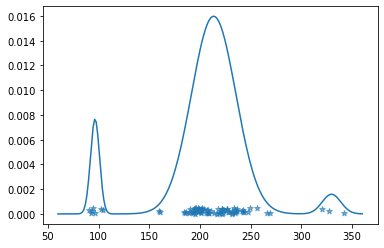

In [ ]:
fig, ax = plt.subplots()
x = np.linspace(60,360,200)

#Your code goes here

plt.show()

**Exercise 2.6** Use the same `scores` data set to fit Gaussian mixture model with either 2 or 4 (you choose!) clusters. Which model is a better fit - the 3-cluster model or your model? How do you know?

## Supervised learning and linear regression

#### Introduction. Labels and Predictors.

What we have seen previously was unsupervised learning. We just had loose data points that we assumed came from the same distribution and saw where that took us. But a lot of the time we have more data and it is strange not to use it! A usual task is to predict that additional set of data by another. For instance, we could have asked the students in previous example how much time had they studied. Then we could try to predict how much a new student has studied based only on his/her test score! Or we could ask more interesting questions such as "does study time determine which cluster the student belongs to?". That is the power of supervised machine learning. 

The "supervised" comes from the fact that labels keep the optimisation in check. This means it cannot just group and so interpret the data freely.

The "main" data points (like test scores in the example) are called - not surprisingly - predictors. The additional data that we want to understand is called a label. 

Labels can be binary. For instance, the predictors can be pictures of tissue converted into real numbers using some smart scheme and the labels are just "tumour" and "not tumour" as labeled by doctors. 

Labels can also be real numbers as in the "hours studied" example. 


### The Data
For this section we will use data from Lithuanian Department of Statistics about the procentage of people that bought a certain type of goods online. 

We can correlated this number to how likely a person is to buy something based on their age group. Of course, this is a naive assumption because the data is quite crude - it tracks self-reported buying behaviour over a period of one year. You can imagine how to take this analysis further if you are running an e-shop and have more fine-grained data.

Lets look at the data!

To get the data you will need to upload the `buy.csv` file using the *Files* panel on the left.

In [ ]:
import pandas

buy = pandas.read_csv('buy.csv')
buy

,2015,2016,2017,2018,2019,age_group,goods
0,31.2,38.6,38.9,38.8,45.6,16-24,Wear
1,2.8,5.2,6.9,5.8,5.3,16-24,Learning material
2,30.8,38.2,41.6,43.0,52.2,25-34,Wear
3,1.4,2.0,6.5,5.4,6.2,25-34,Learning material
4,20.4,25.9,28.2,33.9,38.0,35-44,Wear
5,1.6,2.4,3.8,3.0,4.0,35-44,Learning material
6,10.0,11.0,13.4,16.0,20.5,45-54,Wear
7,0.7,0.9,1.4,2.7,2.0,45-54,Learning material
8,3.6,4.3,5.5,6.8,9.3,55-64,Wear
9,0.2,0.5,0.7,0.6,0.5,55-64,Learning material


To make this analysis more concrete and fun. We will assume that you run an online website that people visit frequently thoughout the year. Furthermore, you sell hats for XX \$ and Data Science course for XXX \$. You can choose an addvertisement for either gloves or your course that the person sees each time they visit your page. At the end of the year you expect they will buy the good you advertised with the probability close to the overall population behaviour based on the [mere-exposure effect](https://en.wikipedia.org/wiki/Mere-exposure_effect). So, based on their age group which add should you show your visitors? 

Whoa, that is a hard (but lucrative) question! We will unpack it bit by bit while learning about supervised learning. For now lets simplify our dataset and look for trends in the "Wear" category.

In [ ]:
w = buy[buy['goods'] == 'Wear']

w

,2015,2016,2017,2018,2019,age_group,goods
0,31.2,38.6,38.9,38.8,45.6,16-24,Wear
2,30.8,38.2,41.6,43.0,52.2,25-34,Wear
4,20.4,25.9,28.2,33.9,38.0,35-44,Wear
6,10.0,11.0,13.4,16.0,20.5,45-54,Wear
8,3.6,4.3,5.5,6.8,9.3,55-64,Wear


Lets also draw a plot for these datapoints! After that we will try to fit a line through these data points.

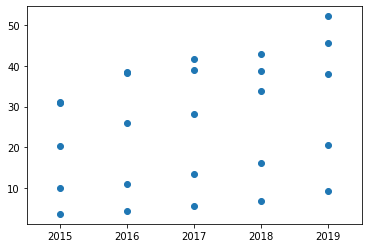

In [ ]:
x = []
y = []
for year in {'2015', '2016', '2017', '2018', '2019'}:
  y += w[year].tolist()
  x += [int(year) for _ in range(w.shape[0])]

fig, ax = plt.subplots()

ax.scatter(x, y)
ax.set_xlim(2014.5,2019.5)
ax.set_xticks([2015,2016,2017,2018,2019])
plt.show()

### First Step 

The first step in a supervised learning task is similar to the first step in unsupervised learning. It is to chose a distribution that we think our sample came from. The only difference is that this time the probablility distribution in addition to parameters also has to include the predictors (in this case - years). 

Lets choose the following model:

$Y$ ~ $a + b\times X + Normal(0, \sigma)$

This model assumes, that the general trend is linear. But the points can be scattered accross a range in a single year. Though matematical mangling this is the same as:  

$Y$ ~ $Normal(a + b\times X, \sigma)$

You can think of this intuitvely as if the general trend line systematically lifts the mean of the Normal. So we will use Normal probability density function as defined earlier.

Do not forget the constraints:

$\sigma \in [0; \infty)$

In [ ]:
import scipy.stats
Pr_N = scipy.stats.norm.pdf

def logPr_Y(y, x, L):
  """
  Calculates log probability of seeing the given label under given parameters
  and predictor values.
  :param y: (real) - sample
  :param x: (real) - predictor  
  :param L: (list [a, b, s]) - list of parameters, s stands for sigma
  :return: (real)
  """
  a, b, s = L
  n = Pr_N(y, a + b*x, s)
  return np.log(n)

### Second step

It is also very similar to the second step we saw previously. The goal of this step is to express the likelihood of observing the current set of parameters. Just this time the likelihood of parameters depends on two sets of data. We write this as: 

$$lik(\Lambda | x_1, ..., x_n, y_1, ..., y_n)$$

Which using independence assumption is the same as:

$$Pr_Y(y_1|x_1, \Lambda)\times ... \times Pr_Y(y_n|x_n, \Lambda)$$

Similarly, as before we will work with log likelihood.

In [ ]:
def loglik(L):
  """
    Calculates log likelihood of the entire dataset under given parameters.
    :param L: (list [a, b, s]) - list of parameters
    :global x: ([2015, ..., 2015, ... 2019, ..., 2019]) - the predictors
    :global y: (list of reals) - the labels (percentages) for the data set  
    :return: (real)
  """
  global x
  global y 
  prx = [logPr_Y(y[i], x[i],L) for i in range(len(y))]
  return sum(prx)

### Third step

Here we can do business as usual: create a helper function to optimise over and recover best estimate parameters.

In [ ]:
def f(T):
  """
  Funtion to be optimised.quadratic
  :param T: [a, b, t] - temporary parameter
  :return: (real)
  """
  a,b,t = T
  s = math.exp(t)
  L = [a,b,s]
  return -loglik(L)

initial_guess = [-6000, 3, 10]

T = scipy.optimize.fmin(f, initial_guess, maxiter=5000)

# Recover lambda
a,b,t = T
s = math.exp(t)
print(a,b,s)

Optimization terminated successfully.
         Current function value: 101.278132
         Iterations: 178
         Function evaluations: 325
-6416.4699376515655 3.1939999689896927 13.904141537761753


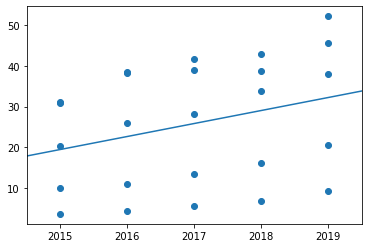

In [ ]:
fig, ax = plt.subplots()
xs = np.linspace(2014.4, 2019.5, 200) 
ys = [a + b*x for x in xs]

ax.scatter(x, y)
ax.plot(xs, ys)
ax.set_xlim(2014.5,2019.5)
ax.set_xticks([2015,2016,2017,2018,2019])
plt.show()

Whoosh! That was a lot of work for a line. What if I told you, that we could have achieved this fit with 4 lines of code! 

In [ ]:
import sklearn.linear_model

one = np.ones(len(y))
model = sklearn.linear_model.LinearRegression(fit_intercept = False)
model.fit(np.column_stack([one, x]), y)

(a,b) = model.coef_
print(a,b)

-6416.46999999986 3.193999999999931


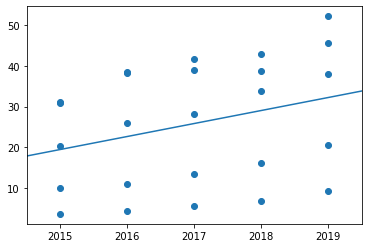

In [ ]:
fig, ax = plt.subplots()
xs = np.linspace(2014.4, 2019.5, 200) 
ys = [a + b*x for x in xs]

ax.scatter(x, y)
ax.plot(xs, ys)
ax.set_xlim(2014.5,2019.5)
ax.set_xticks([2015,2016,2017,2018,2019])
plt.show()

### Linear Regression

In fact the model that we so ardously fitted is a *linear model* and we can just use a method called *linear regression* to fit it. Lets unpack this statement.

A linear model can be writen like so:

$$y = \beta_1\times e_1 + ... + \beta_K \times e_K + \epsilon$$

$y$ in this notation is also called response vector and is a vector (i.e. a list of values) of our labels. $e_1, ... e_k$ are called feature vectors and contains the data we are predicting $y$ from. $\beta_1, ... ,\beta_K$ are feature weights - the parameters we are estimating. $\epsilon$ is a vector of residuals - some small value that our linear model cannot capture.

Linear regression then just picks $\beta_1, ..., \beta_K$ so that to minimise the residuals. To not favour negative values, linear regression actually minimises $\frac{\sum_i\epsilon_i^2}{n}$.

In the previous example our linear model was:

$$y = a\times 1 + b\times x + \epsilon$$

Where $1$ is a vector of all ones. The normal term $Normal(0, \sigma)$ stood for the residual error $\epsilon$. So the two models are equivalent - that is why we got almost exactly the same line.

We can quickly "improve" our linear model, lets see what happens if we add quadratic term, i.e. modeling:

$$y = a\times 1 + b\times x + c \times x^2+ \epsilon$$

661944.9652598372 -659.5345709782902 0.16428571417418425


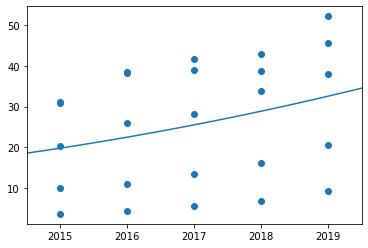

In [ ]:
one = np.ones(len(y))
model = sklearn.linear_model.LinearRegression(fit_intercept = False)
x_sq = [w*w for w in x]
model.fit(np.column_stack([one, x, x_sq]), y)

(a,b, c) = model.coef_
print(a,b, c)

fig, ax = plt.subplots()
xs = np.linspace(2014.4, 2019.5, 200) 
ys = [a + b*x + c*x*x for x in xs]

ax.scatter(x, y)
ax.plot(xs, ys)
ax.set_xlim(2014.5,2019.5)
ax.set_xticks([2015,2016,2017,2018,2019])
plt.show()

The line got a little bit fancier! That is if you can see the slight bend that the line shows... It is only so far that we can get with this kind of analysis. What is more interesting is how the trend lines differ for different age groups.

Here is a plot where I have highlighted different age groups with different colours.


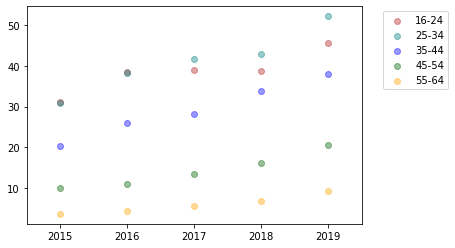

In [ ]:
fig, ax = plt.subplots()
years = ['2015','2016','2017','2018','2019']
years_int = [int(yr) for yr in years]

z = zip(w['age_group'].tolist(), ['firebrick', 'teal', 'blue', 'darkgreen', 'orange'])
for i,c in z:
  ys = [w[w['age_group']==i][yr].tolist()[0] for yr in years]
  ax.scatter(years_int, ys, color = c, alpha=.4, label=i)

ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax.set_xlim(2014.5,2019.5)
ax.set_xticks(years_int)
plt.show()

### One hot encoding

How can we fit a quadratic trend line through each of them?

One useful trick is what is called "one-hot encoding". With it we assume that there is a seperate a, b, and c for each age group:

$$y_{group} \approx a_{group} + b_{group}\times x + c_{group}\times x^2$$

What is cool is that we can implement all these trend lines within the same model. The key is to create a vector for each group and place 1 where the data point belongs to that group and 0 otherwise. I could do fancy 'pandas' mangling but since I have laid out my data year by year I could just mark every fifth entry! I will put them in a list just for convenience

In [ ]:
ones_16_24 = [int(i % 5 == 0) for i in range(len(x))]
ones_25_34 = [int(i % 5 == 1) for i in range(len(x))]
ones_35_44 = [int(i % 5 == 2) for i in range(len(x))]
ones_45_54 = [int(i % 5 == 3) for i in range(len(x))]
ones_55_64 = [int(i % 5 == 4) for i in range(len(x))]
one_list = [ones_16_24,ones_25_34, ones_35_44, ones_45_54, ones_55_64]
one_list

[[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]]

In the following code snippet I additionally convert Python lists to numpy arrays, which makes it possible to do vectorised operations. For instance, raise each element of the list by the power of two or multiplity elements with the same index. Of course, this can also be achieved with a loop, but we are here to explore as much as possible of the neat Python features!

In [ ]:
x_vector = np.array(x)
y_vector = np.array(y)
x_vector_sq = x_vector**2
ones_vector = [np.array(one) for one in one_list]

feature_vectors = []

for one in ones_vector:
  feature_vectors += [one, x_vector*one,x_vector_sq*one]

Now, it is time to fit the model. We will get 15 coeficients because we have 5 age groups and are fitting a quadratic curve through each one.

In [ ]:
import sklearn.linear_model

model = sklearn.linear_model.LinearRegression(fit_intercept = False)
model.fit(np.column_stack(feature_vectors), y_vector)

weights = model.coef_
print(weights)

[-4.70781080e+05  4.63951689e+02 -1.14291445e-01  4.55331073e+05
 -4.56212791e+02  1.14271886e-01  1.65671002e+05 -1.68565717e+02
  4.28571428e-02  2.08703187e+06 -2.07202857e+03  5.14285714e-01
  1.07239240e+06 -1.06473857e+03  2.64285714e-01]


That was quick! The hardest part is now to untangle the weights and turn them into a reasonably looking graph.

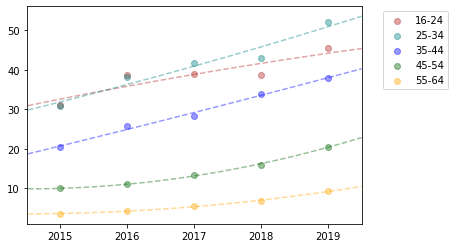

In [ ]:
fig, ax = plt.subplots()
years = ['2015','2016','2017','2018','2019']
years_int = [int(yr) for yr in years]

z = zip(w['age_group'].tolist(), ['firebrick', 'teal', 'blue', 'darkgreen', 'orange'])
for i,c in z:
  ys = [w[w['age_group']==i][yr].tolist()[0] for yr in years]
  ax.scatter(years_int, ys, color = c, alpha=.4, label=i)

xs = np.linspace(2014.4, 2019.5, 200) 
z = zip([i for i in range(5)], ['firebrick', 'teal', 'blue', 'darkgreen', 'orange'])
for i,c in z:
  ys = [weights[i*3] + weights[i*3+1]*x + weights[i*3+2]*x*x for x in xs]
  ax.plot(xs, ys, color = c, alpha=.4, linestyle='--')

ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax.set_xlim(2014.5,2019.5)
ax.set_xticks(years_int)
plt.show()

We can now see the trend lines for each age group! This makes it easier to answer questions for each age group related to advertisement. What is left is to do the same for Learning Material. 

**Exercise 2.7** Fit quadratic trend lines through data points for Learning Material. You should also get 15 weight - call the list of wwights `weights_lm` to differentiate them from the weights we got before. Then we will be able to return to the original questions. If you feel like strenghtening your Python skills, generate the graph for each trend line (as in the code snippet before) - but that is not neccesary.

   2015  2016  2017  2018  2019 age_group              goods
1   2.8   5.2   6.9   5.8   5.3     16-24  Learning material
3   1.4   2.0   6.5   5.4   6.2     25-34  Learning material
5   1.6   2.4   3.8   3.0   4.0     35-44  Learning material
7   0.7   0.9   1.4   2.7   2.0     45-54  Learning material
9   0.2   0.5   0.7   0.6   0.5     55-64  Learning material


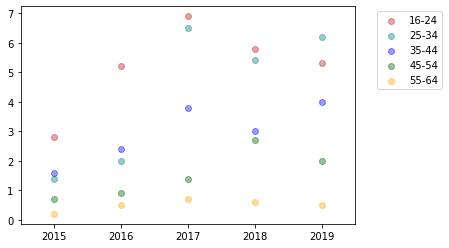

In [ ]:
# Clean up table
lm = buy[buy['goods'] == 'Learning material']
print(lm)

# Turn the table into lists
x = []
y = []
for year in {'2015', '2016', '2017', '2018', '2019'}:
  y += lm[year].tolist()
  x += [int(year) for _ in range(lm.shape[0])]

# Generate a simple graph for illustration
fig, ax = plt.subplots()
years = ['2015','2016','2017','2018','2019']
years_int = [int(yr) for yr in years]

z = zip(lm['age_group'].tolist(), ['firebrick', 'teal', 'blue', 'darkgreen', 'orange'])
for i,c in z:
  ys = [lm[lm['age_group']==i][yr].tolist()[0] for yr in years]
  ax.scatter(years_int, ys, color = c, alpha=.4, label=i)

ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax.set_xlim(2014.5,2019.5)
ax.set_xticks(years_int)
plt.show()

[-2.50013741e+06  2.47851173e+03 -6.14266666e-01 -1.51351400e+06
  1.49946255e+03 -3.71383873e-01 -5.24151706e+05  5.19197150e+02
 -1.28571428e-01 -2.91477868e+05  2.88582857e+02 -7.14285715e-02
 -3.19791811e+05  3.17027143e+02 -7.85714285e-02]


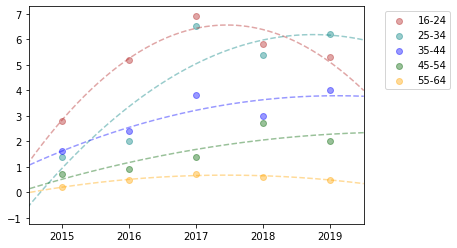

In [ ]:
# Continue from here!

model = sklearn.linear_model.LinearRegression(fit_intercept = False)
model.fit(np.column_stack(feature_vectors), y)

weights_lm = model.coef_
print(weights_lm)

fig, ax = plt.subplots()
years = ['2015','2016','2017','2018','2019']
years_int = [int(yr) for yr in years]

z = zip(lm['age_group'].tolist(), ['firebrick', 'teal', 'blue', 'darkgreen', 'orange'])
for i,c in z:
  ys = [lm[lm['age_group']==i][yr].tolist()[0] for yr in years]
  ax.scatter(years_int, ys, color = c, alpha=.4, label=i)

xs = np.linspace(2014.4, 2019.5, 200) 
z = zip([i for i in range(5)], ['firebrick', 'teal', 'blue', 'darkgreen', 'orange'])
for i,c in z:
  ys = [weights_lm[i*3] + weights_lm[i*3+1]*x + weights_lm[i*3+2]*x*x for x in xs]
  ax.plot(xs, ys, color = c, alpha=.4, linestyle='--')

ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax.set_xlim(2014.5,2019.5)
ax.set_xticks(years_int)
plt.show()

### Conclusion

The year is 2020 and we now care about the advertisement question:

You run an online website that people visit frequently thoughout the year. Furthermore, you sell hats for 9 \$ and Data Science course for 99 \$. You can choose an addvertisement for either gloves or your course that the person sees each time they visit your page. At the end of the year you expect they will buy the good you advertised with the probability close to the overall population behaviour. So, based on their age group which add should you show them? 

Firstly we will calculated the expected proportion of the population that buys a particular item based on the weights we caculated earlier. Then, since we equate this number to the probability that a person buys something from your website this year, we can calculate the expected amount of money a person will spend on your website this year. Then, comparing this expected value through the different age groups we get the final result - which add should you show to which person. You can now turn this answer into a neat table and show your marketing division!

In [ ]:
year = 2020
wear = np.empty(5)
learn_mat = np.empty(5)

for i in range(5):
  wear[i] = 0.01 * (weights[i*3] + weights[i*3+1]*year + weights[i*3+2]*year*year)
  learn_mat[i] = 0.01 * (weights_lm[i*3] + weights_lm[i*3+1]*year + weights_lm[i*3+2]*year*year)

cost_wear = 9
cost_lm = 99
show_glove_add = wear*cost_wear >= learn_mat*cost_lm
age_groups = ['16-24', '25-34', '35-44', '45-54', '55-64']

print(['16-24', '25-34', '35-44', '45-54', '55-64'])
print(show_glove_add)


['16-24', '25-34', '35-44', '45-54', '55-64']
[ True False  True False  True]


**Exercise 2.8** Google Colab handily provides some classical data to experiment with. One of these datasets is [Anscombe's queartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet). Using linear regression fit a straight line through each of the four data sets and draw four graphs. You will have to prepare the data first. An example, of how I would do it is given bellow! Do you get the fit similar to the ones in Wikipedia page?

In [ ]:
import json
with open('sample_data/anscombe.json') as f:
  data = json.load(f)
print(data)

x_I = []
y_I = []

for i in data:
  if i['Series'] == 'I':
    x_I += [i['X']]
    y_I += [i['Y']]

**Exercise 2.9** This is an exercise in creating models for supervised learning. In the following 80 point data set there is an inflection point with x coordinate $\theta$. So parameters for this model should be $\theta$ in addition to those for the two lines. Create and fit a model for this data set to estimate the $\theta$. You can use Linear Regression for this if you want. This is quite a hard exercise - be careful not to fit two separate lines! Here is an illustration for this data set:

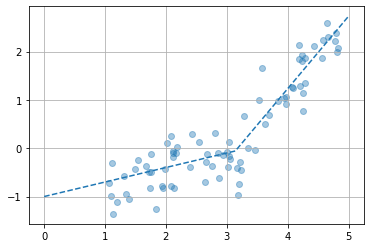

In [ ]:
x_sample = [3.21, 4.26, 3.18, 2.66, 4.65, 2.12, 4.2, 1.34, 2.65, 3.94, 2.12, 3.7, 3.97, 2.4, 4.57, 3.2, 2.8, 2.43, 3.23, 1.19, 3.02, 4.43, 4.28, 1.13, 1.72, 1.74, 4.28, 4.58, 2.94, 4.24, 4.83, 1.96, 4.19, 1.4, 4.23, 2.68, 1.11, 1.06, 3.29, 4.81, 2.86, 3.53, 1.99, 1.67, 2.75, 3.58, 3.97, 4.67, 4.78, 4.07, 3.17, 1.93, 2.16, 3.62, 2.14, 1.75, 3.35, 2.08, 1.1, 2.09, 3.05, 4.19, 1.31, 2.18, 4.09, 3.03, 3.47, 3.03, 2.02, 1.54, 2.87, 1.5, 4.79, 1.83, 3.0, 1.76, 2.12, 3.84, 4.25, 2.55]
y_sample = [-0.29, 1.15, -0.97, -0.28, 2.6, -0.1, 1.28, -0.94, -0.7, 1.03, -0.05, 0.69, 1.07, -0.39, 1.86, -0.75, 0.31, 0.3, -0.46, -1.12, -0.38, 2.11, 1.36, -1.36, -0.5, -0.83, 1.86, 2.23, -0.15, 1.81, 2.07, -0.83, 2.14, -1.06, 1.92, -0.12, -0.3, -0.72, 0.66, 1.99, -0.09, 0.99, -0.43, -0.36, -0.37, 1.66, 0.92, 2.31, 2.21, 1.27, -0.41, -0.79, -0.1, 0.51, -0.82, -0.12, 0.01, 0.25, -0.99, -0.79, -0.23, 1.85, -0.57, 0.02, 1.24, 0.13, -0.03, -0.16, 0.11, -0.25, -0.62, -0.42, 2.38, -1.26, -0.07, -0.5, -0.19, 0.97, 0.78, 0.13]